# Importing the Necessary Libraries

In [69]:
#!pip install idx2numpy

In [71]:
import numpy as np
import idx2numpy
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from skimage import data, exposure
import pandas as pd


In [72]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [73]:
import csv
def write_to_file(file_name, values, header_names=False):
    with open(file_name, 'w') as writeFile:
        writer = csv.writer(writeFile)
        if header_names:
            writer.writerow(header_names)
        writer.writerows(values)

In [74]:
#!pip install keras
#!pip install tensorflow

# deeper cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist

#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [75]:
# load train and test dataset
def load_dataset():
    
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
 

In [76]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [77]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    #opt = SGD(lr=0.01, momentum=0.9)
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [78]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    i = 0

    t_acc = 0
    t_pre = 0
    t_rec = 0
    t_f1 = 0

    for train_ix, test_ix in kfold.split(dataX):
        i += 1 
        # define model
        model = define_model()
        
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        
        print('> %.3f' % (acc * 100.0))
        
        ###########################
        # predict probabilities for test set
        yhat_probs = model.predict(testX, verbose=0)
        # predict crisp classes for test set
        
        #yhat_classes = model.predict_classes(testX, verbose=0)
        yhat_classes = np.argmax(yhat_probs,axis=1)
        
        
        # reduce to 1d array
        yhat_probs = yhat_probs[:, 0]
        #yhat_classes = yhat_classes[:, 0]
        testY = np.sum(testY * [0,1,2,3,4,5,6,7,8,9], axis=1).reshape(testY.shape[0], )
        
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(testY, yhat_classes)
        t_acc += accuracy

        # precision tp / (tp + fp)
        precision = precision_score(testY, yhat_classes, average='macro')
        t_pre += precision

        # recall: tp / (tp + fn)
        recall = recall_score(testY, yhat_classes, average='macro')
        t_rec += recall
        
        # f1: 2 tp / (2 tp + fp + fn)
        #f1 = f1_score(testY, yhat_classes, average='weighted')
        f1 = (2 * precision * recall)/ (precision + recall)

        t_f1 += f1
        
        ###############################
        
        # stores scores
        scores.append(acc)
        histories.append(history)
    
    print("Average Values")
    print('Accuracy: %f' % ((t_acc/i)*100))
    print('Precision: %f' % ((t_pre/i)*100))
    print('Recall: %f' % ((t_rec/i)*100))
    print('F1-Score: %f' % ((t_f1/i)*100))
    
    return scores, histories
 


In [79]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        # plot accuracy
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()

    

In [80]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

In [81]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
trainX.shape

(60000, 28, 28, 1)

In [82]:
trainY.shape

(60000, 10)

In [83]:
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)


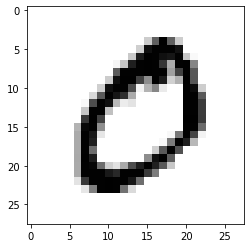

In [84]:
plt.imshow(trainX[1], cmap=plt.cm.binary)

In [85]:
trainXX = trainX[0:3000]
trainYY = trainY[0:3000]

In [87]:
data2 = pd.read_csv('data/mnist_outside.csv')
data2.shape
partial_df = data2.to_numpy()
partial_df.shape


(139, 1)

In [21]:
#for i in partial_df:
#    plt.imshow(trainX[i][0], cmap=plt.cm.binary)
#    plt.savefig('data/partial/' + str(i) + '.pdf') 

In [22]:
print(trainXX.shape)
print(trainYY.shape)

(3000, 28, 28, 1)
(3000, 10)


### CNN Results Before Foreign Elements Rejection

In [23]:
# evaluate model
scores, histories = evaluate_model(trainXX, trainYY)
histories

> 95.667
> 97.000
> 96.167
> 96.333
> 97.500
Average Values
Accuracy: 96.533333
Precision: 96.535702
Recall: 96.518069
F1-Score: 96.526808


### CNN Results After Foreign Elements Rejection

In [24]:
trainXX2 = np.delete(trainXX, partial_df, axis=0)
trainYY2 = np.delete(trainYY, partial_df, axis=0)

In [25]:
print(trainXX2.shape)
print(trainYY2.shape)

(2769, 28, 28, 1)
(2769, 10)


In [26]:
scores, histories = evaluate_model(trainXX2, trainYY2)
histories

> 99.458
> 97.834
> 98.556
> 98.195
> 98.915
Average Values
Accuracy: 98.591666
Precision: 98.586389
Recall: 98.585349
F1-Score: 98.585861


<ipython-input-9-5bcb12a080cf>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 1)
<ipython-input-9-5bcb12a080cf>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  pyplot.subplot(2, 1, 2)


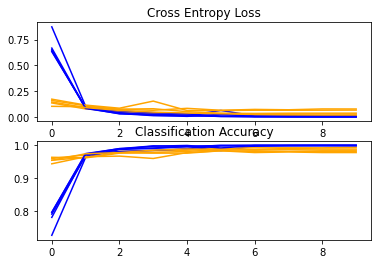

In [27]:
# learning curves
summarize_diagnostics(histories)

Accuracy: mean=98.592 std=0.564, n=5


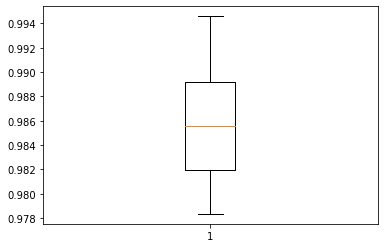

In [28]:
# summarize estimated performance
summarize_performance(scores)

## SVM Training

In [37]:
from sklearn import svm

clf = svm.SVC(C=16, kernel='linear', gamma='auto')

### SVM Results Before Foreign Elements Rejection

In [38]:
trainXSVM = trainX[0:3000].reshape(3000, 784)
trainYSVM = np.sum(trainY[0:3000] * [0,1,2,3,4,5,6,7,8,9], axis=1).reshape(3000, )

In [39]:
trainYSVM.shape

(3000,)

In [40]:
#Before 80% Training0
clf.fit(trainXSVM[0:2400], trainYSVM[0:2400])

SVC(C=16, gamma='auto', kernel='linear')

In [41]:
#Before 20% Testing
predicted = clf.predict(trainXSVM[2400:])


In [42]:
print(trainYSVM[2400:].shape)
print(predicted.shape)

(600,)
(600,)


In [43]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYSVM[2400:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYSVM[2400:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYSVM[2400:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [44]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 91.000000
Precision: 90.778645
Recall: 90.336332
F1-Score: 90.556948


### SVM Results After Foreign Elements Rejection

In [45]:
trainXSVM2 = np.delete(trainXSVM, partial_df, axis=0)
trainYSVM2 = np.delete(trainYSVM, partial_df, axis=0)

In [46]:
#After 80% Training
clf.fit(trainXSVM2[0:2220], trainYSVM2[0:2220])


SVC(C=16, gamma='auto', kernel='linear')

In [47]:
#After 20% Testing
predicted = clf.predict(trainXSVM2[2220:])

In [48]:
print(trainYSVM2[2220:].shape)
print(predicted.shape)

(549,)
(549,)


In [49]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYSVM2[2220:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYSVM2[2220:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYSVM2[2220:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)


In [50]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))


Average Values
Accuracy: 95.810565
Precision: 95.800093
Recall: 95.339396
F1-Score: 95.569189


In [ ]:
456

## Random Forest Classifier Training

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)

### Random Forest Classifier Results Before Foreign Elements Rejection

In [52]:
trainXRF = trainX[0:3000].reshape(3000, 784)
trainYRF = np.sum(trainY[0:3000] * [0,1,2,3,4,5,6,7,8,9], axis=1).reshape(3000, )

In [53]:
clf.fit(trainXRF[0:2400], trainYRF[0:2400])


RandomForestClassifier(max_depth=2, random_state=0)

In [54]:
predicted = clf.predict(trainXRF[2400:])

In [55]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYRF[2400:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYRF[2400:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYRF[2400:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [56]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 63.500000
Precision: 73.578856
Recall: 60.494746
F1-Score: 66.398368


### Random Forest Classifier Results After Foreign Elements Rejection

In [57]:
trainXRF2 = np.delete(trainXRF, partial_df, axis=0)
trainYRF2 = np.delete(trainYRF, partial_df, axis=0)

In [58]:
clf.fit(trainXRF2[0:2220], trainYRF2[0:2220])

RandomForestClassifier(max_depth=2, random_state=0)

In [59]:
predicted = clf.predict(trainXRF2[2220:])
predicted.shape

(549,)

In [60]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYRF2[2220:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYRF2[2220:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYRF2[2220:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [61]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 66.302368
Precision: 77.207197
Recall: 62.346397
F1-Score: 68.985547


In [62]:
confusion_matrix(trainYRF2[2220:], predicted).ravel()

array([53,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0, 73,  0,  0,  0,  0,  0,
        0,  0,  0,  3, 10, 34,  0,  0,  0,  4,  2,  0,  0,  4, 21,  0, 25,
        2,  1,  0,  4,  0,  1,  1,  1,  0,  0, 50,  0,  0,  4,  0,  0, 10,
        6,  0,  4, 13, 10,  1,  6,  0,  1,  2,  6,  0,  0,  7,  0, 47,  1,
        0,  0,  0,  3,  0,  0,  3,  0,  0, 54,  0,  0,  1, 17,  3,  0,  2,
        0,  1,  1, 10,  0,  0,  1,  0,  0, 21,  0,  0, 15,  0,  8])

## Decision Tree Classifier

In [63]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()

### Decision Tree Classifier Results Before Foreign Elements Rejection

In [64]:
trainXDT = trainX[0:3000].reshape(3000, 784)
trainYDT = np.sum(trainY[0:3000] * [0,1,2,3,4,5,6,7,8,9], axis=1).reshape(3000, )

In [65]:
clf.fit(trainXDT[0:2400], trainYDT[0:2400])

DecisionTreeClassifier()

In [66]:
predicted = clf.predict(trainXDT[2400:])
predicted.shape

(600,)

In [67]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYDT[2400:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYDT[2400:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYDT[2400:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [68]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 74.000000
Precision: 74.368654
Recall: 73.050142
F1-Score: 73.703502


In [69]:
4000*.8

3200.0

### Decision Tree Classifier Results After Foreign Elements Rejection

In [70]:
trainXDT2 = np.delete(trainXDT, partial_df, axis=0)
trainYDT2 = np.delete(trainYDT, partial_df, axis=0)

In [71]:
clf = clf.fit(trainXDT2[0:2220], trainYDT2[0:2220])

In [72]:
predicted = clf.predict(trainXDT2[2220:])

In [73]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYDT2[2220:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYDT2[2220:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYDT2[2220:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [76]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 80.692168
Precision: 80.018710
Recall: 79.985708
F1-Score: 80.002205


## Gaussian Naive Bayes Classifier

In [77]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

### Gaussian Naive Bayes Classifier Results Before Foreign Elements Rejection

In [78]:
trainXNB = trainX[0:3000].reshape(3000, 784)
trainYNB = np.sum(trainY[0:3000] * [0,1,2,3,4,5,6,7,8,9], axis=1).reshape(3000, )

In [79]:
clf = clf.fit(trainXNB[0:2400], trainYNB[0:2400])

In [80]:
predicted = clf.predict(trainXNB[2400:])

In [81]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYNB[2400:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYNB[2400:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYNB[2400:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [82]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 56.666667
Precision: 60.332701
Recall: 56.443010
F1-Score: 58.323075


### Gaussian Naive Bayes Classifier Results After Foreign Elements Rejection

In [159]:
trainXNB2 = np.delete(trainXNB, partial_df, axis=0)
trainYNB2 = np.delete(trainYNB, partial_df, axis=0)

In [160]:
clf = clf.fit(trainXNB2[0:2220], trainYNB2[0:2220])

In [161]:
predicted = clf.predict(trainXNB2[2220:])

In [162]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYNB2[2220:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYNB2[2220:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYNB2[2220:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [163]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 62.112933
Precision: 66.939176
Recall: 61.762789
F1-Score: 64.246885


## KNN Classifier

In [164]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)

### KNN Classifier Results Before Foreign Elements Rejection

In [165]:
trainXKN = trainX[0:3000].reshape(3000, 784)
trainYKN = np.sum(trainY[0:3000] * [0,1,2,3,4,5,6,7,8,9], axis=1).reshape(3000, )

In [168]:
clf = clf.fit(trainXKN[0:2400], trainYKN[0:2400])

In [169]:
predicted = clf.predict(trainXKN[2400:])

In [170]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYKN[2400:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYKN[2400:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYKN[2400:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [171]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 91.833333
Precision: 91.930942
Recall: 91.215329
F1-Score: 91.571737


### KNN Classifier Results After Foreign Elements Rejection

In [172]:
trainXKN2 = np.delete(trainXKN, partial_df, axis=0)
trainYKN2 = np.delete(trainYKN, partial_df, axis=0)

In [175]:
clf = clf.fit(trainXKN2[0:2220], trainYKN2[0:2220])

In [176]:
predicted = clf.predict(trainXKN2[2220:])

In [177]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(trainYKN2[2220:], predicted)

# precision tp / (tp + fp)
precision = precision_score(trainYKN2[2220:], predicted, average='macro')

# recall: tp / (tp + fn)
recall = recall_score(trainYKN2[2220:], predicted, average='macro')

# f1: 2 tp / (2 tp + fp + fn)
f1 = (2 * precision * recall)/ (precision + recall)

In [178]:
print("Average Values")
print('Accuracy: %f' % (accuracy*100))
print('Precision: %f' % (precision*100))
print('Recall: %f' % (recall*100))
print('F1-Score: %f' % (f1*100))

Average Values
Accuracy: 97.085610
Precision: 97.152750
Recall: 96.850625
F1-Score: 97.001452


## Conversion to PCA 

In [113]:
trainYY = np.sum(trainY*[0,1,2,3,4,5,6,7,8,9], axis=1)
testYY = np.sum(testY*[0,1,2,3,4,5,6,7,8,9], axis=1)
datasetY = dataset = np.vstack((trainYY.reshape(60000,1), testYY.reshape(10000,1)))

datasetY[:5]
trainX.shape

(60000, 28, 28, 1)

In [114]:
datasetX = np.vstack((trainX.reshape(60000,784), testX.reshape(10000,784)))
datasetX.shape

(70000, 784)

In [118]:
dataset784 = np.hstack((datasetX.reshape(70000,784), datasetY.reshape(70000,1)))
dataset784.shape

(70000, 785)

In [120]:
features = ['Col'+str(i+1) for i in range(784)]
features.append('L')

write_to_file('data/mnist.csv', dataset784[0:3000].reshape(3000,785), features)

In [115]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(datasetX)
pca_result.shape

(70000, 2)

In [116]:
dataset = np.hstack((pca_result.reshape(70000,2), datasetY.reshape(70000,1)))
dataset.shape

(70000, 3)

In [117]:
write_to_file('data/mnist_pca.csv', dataset[0:3000], ['Col1', 'Col2', 'L'])

## Reading from idx-ubyte files

In [ ]:
imagefile = 'data/train-images.idx3-ubyte'
trainX = idx2numpy.convert_from_file(imagefile)
plt.imshow(trainX[3], cmap=plt.cm.binary)

imagefile = 'data/train-labels.idx1-ubyte'
trainY = idx2numpy.convert_from_file(imagefile)

imagefile = 'data/t10k-images.idx3-ubyte'
testX = idx2numpy.convert_from_file(imagefile)
imagefile = 'data/t10k-labels.idx1-ubyte'
testY = idx2numpy.convert_from_file(imagefile)

In [ ]:
def calc_hog_features(X, image_shape=(28, 28), pixels_per_cell=(8, 8)):
    fd_list = []
    for row in X:
        img = row.reshape(image_shape)
        fd = hog(img, orientations=8, pixels_per_cell=pixels_per_cell, cells_per_block=(1, 1))
        fd_list.append(fd)
    
    return np.array(fd_list)


In [ ]:
X_train = calc_hog_features(trainX, pixels_per_cell=(8, 8))
plt.imshow(X_train[17].reshape(9,8), cmap=plt.cm.binary)

In [ ]:
features = ['Col'+str(i+1) for i in range(784)]
features.append('L')
#features

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(trainX.reshape(60000,784))

pca_result

In [ ]:
merged_test = np.hstack((pca_result[0:3000], trainY[0:3000].reshape(3000,1)))
#write_to_file('data/mnist_pca_train.csv', merged_test, ['Col1', 'Col2', 'L'])
pca_hog_result = pca.fit_transform(X_train)


In [ ]:
hog_pca = np.hstack((pca_hog_result[0:3000], trainY[0:3000].reshape(3000,1)))
hog_pca.shape

In [ ]:
write_to_file('data/mnist_pca_hog_train.csv', hog_pca, ['Col1', 'Col2', 'L'])